# Transformer Architecture

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#print("Device:", tpu.master())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133 kB 12.5 MB/s 


In [2]:
pip install clean-text[gpl]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 175 kB 28.9 MB/s 
     |████████████████████████████████| 235 kB 73.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=ee48d6404817eee81d8340a1fde0f86ed80799b8658c088e2a42a9bccdd33bc1
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
from cleantext import clean

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#Read in data
path_to_csv = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/cyberbullying_tweets.csv'
df=pd.read_csv(path_to_csv)

# Cleaning and Organizing Data

In [8]:
#looking at original data observation with emojis and urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [9]:
#function for cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="") #removing emojies and urls 
    return text



In [10]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [11]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojies or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,uh. why do they not make these for grownups?,not_cyberbullying
1040,omg i have a feeling i'm going to be overwhelmed by my emoticons in tomorrow's #mkr,not_cyberbullying


In [12]:
#dropping duplicates
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45603, 2)

In [13]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7974
age                    7952
ethnicity              7946
other_cyberbullying    7720
gender                 7651
not_cyberbullying      6360
Name: cyberbullying_type, dtype: int64

In [14]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7974
1    7952
3    7946
5    7720
2    7651
4    6360
Name: label_values, dtype: int64

In [16]:
#Splitting dataset into full_train and test sets, stratifying on labels.

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [17]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7100
1    7080
3    7075
5    6873
2    6812
4    5663
Name: label_values, dtype: int64

In [18]:
#making sure test set is stratified properly
y_test.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

In [19]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [20]:
#making sure train set is stratified properly
y_train.value_counts()

0    6226
1    6208
3    6204
5    6026
2    5973
4    4966
Name: label_values, dtype: int64

In [21]:
#making sure validation set is stratified properly
y_val.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

# Data Preprocessing and Tokenization

In [22]:
#Tokenized text for X_train and X_val and X_test. Fit on train first then text_to_sequences on train,
#validation and test sets
max_tokens=30000
tokenizer =Tokenizer(num_words=max_tokens, oov_token="OOV")
tokenizer.fit_on_texts(X_train)
X_train_token=tokenizer.texts_to_sequences(X_train)
X_val_token=tokenizer.texts_to_sequences(X_val)
X_test_token=tokenizer.texts_to_sequences(X_test)

In [23]:
#check how many unique tokens
word_index=tokenizer.word_index
number_of_words=len(word_index)
print("Number of tokens",number_of_words )

Number of tokens 49098


In [24]:
#pad sequences for tokenized X_train, X_val and X_test
#set max length of text to 70 tokens
max_len=70
X_train_token_pad=pad_sequences(X_train_token, maxlen=max_len, padding="post", truncating="post")



X_val_token_pad=pad_sequences(X_val_token,maxlen= max_len , padding="post", truncating="post")
X_test_token_pad=pad_sequences(X_test_token,maxlen= max_len,padding="post", truncating="post")
X_val_token_pad.shape

(5000, 70)

# Helpful Model Fitting and Results Functions

In [25]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [26]:

def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3, optimizer='adam'):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=128,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
        
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                       
  

    return history, model   

In [27]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [28]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [29]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [30]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ["religion",
                       "age",
                       "gender",
                       "ethnicity",
                       "not_cyberbullying",
                       "other_cyberbullying"
]



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# Experiment 7 - Transformer followed by 2 Dense Layers - Hyperparemeter Tunning

In [31]:
#Experiment 7 model 
#Code from Chollet (2021)
#Chollet, Francois. 2021. Deep Learning with Python. 2nd edition. Manning Publications.

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config



class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
      
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [36]:
keras.backend.clear_session()

In [37]:
#Experiment 7 model 
#create model for KerasTuner hyperparameter testing

num_heads = 2
def create_model_exp_7(hp):
    
    model=Sequential()
    #tunning for different number of embedding output dimensions min of 100, max of 400 and any in between by multiples of 100
    embed_dim = hp.Choice('Embedding_Output_Dimension',[100,200,300,400])
    #testing for a min of 32 nodes, a max of 256 filters and any in between by multiples of 32, for TransformerEncoder
    transformer_dense_dim=hp.Int('TransformerEncoder # of Dense Nodes',min_value=32, max_value=256, step =32)
    #testing for a min of 32 nodes, a max of 256 filters and any in between by multiples of 32, for Dense hidden layers
    dense_layer_nodes_1=hp.Int('Dense Layer 1 # of Dense Nodes',min_value=32, max_value=256, step =32)
    dense_layer_nodes_2=hp.Int('Dense Layer 2 # of Dense Nodes',min_value=32, max_value=256, step =32)


    model.add(Input(shape=(None,), dtype="int64"))
    model.add(PositionalEmbedding(max_len, max_tokens, embed_dim))
    model.add(TransformerEncoder(embed_dim, transformer_dense_dim, num_heads))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout (hp.Float("Dropout_GlobalMaxPooling1D", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense( dense_layer_nodes_1 , activation="relu"))
    #testing for dropout - 0.1 to 0.4 by increments of 0.1
    model.add(Dropout (hp.Float("Dropout_Dense_1", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense( dense_layer_nodes_2 , activation="relu"))
    #testing for dropout - 0.1 to 0.4 by increments of 0.1
    model.add(Dropout (hp.Float("Dropout_Dense_2", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation="softmax"))
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model


create_model_exp_7(kt.HyperParameters())

In [38]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_7 = kt.BayesianOptimization(
    hypermodel=create_model_exp_7,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    #distribution_strategy=strategy_exp_7,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_7")

In [39]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="7"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_7.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 00m 13s]
val_accuracy: 0.8795999884605408

Best val_accuracy So Far: 0.8853999972343445
Total elapsed time: 00h 06m 57s
INFO:tensorflow:Oracle triggered exit


In [41]:
#getting best hyperparameters for model 
best_hyper_parameters_exp_7=tuner_exp_7.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many Conv layers there are
def best_model_hyperparameters_7(bhp):
    print("Embedding_Output_Dimension: {}".format(bhp.get('Embedding_Output_Dimension')))
    print("\n")
    print("TransformerEncoder # of Dense Nodes: {}".format(bhp.get("TransformerEncoder # of Dense Nodes")))
    print('Dropout After GLobalMaxPooling1D Layer:', bhp.get('Dropout_GlobalMaxPooling1D'))
    print("\n")
    
    print("Dense Layer 1 # of Nodes: {}:".format(bhp.get('Dense Layer 1 # of Dense Nodes')))
    print('Dropout for Dense Layer 1:', bhp.get("Dropout_Dense_1"))
    print("\n")
    
    print("Dense Layer 2 # of Nodes: {}:".format(bhp.get("Dense Layer 2 # of Dense Nodes")))
    print('Dropout for Dense Layer 2:', bhp.get("Dropout_Dense_2"))
    print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_7(best_hyper_parameters_exp_7)  

Embedding_Output_Dimension: 100


TransformerEncoder # of Dense Nodes: 256
Dropout After GLobalMaxPooling1D Layer: 0.1


Dense Layer 1 # of Nodes: 256:
Dropout for Dense Layer 1: 0.4


Dense Layer 2 # of Nodes: 256:
Dropout for Dense Layer 2: 0.1


Optimizer Used: adam


In [42]:
#getting paremeters of best model
model_exp_7_best_params = tuner_exp_7.get_best_hyperparameters(2)

# Building model exp_7 with best hyper parameters
model_exp_7_best = create_model_exp_7(model_exp_7_best_params[0])


# Running best model 7 to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=3
model_number="7"
history_exp_7, model_exp_7 = compile_train_model(model_exp_7_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="adam")

Epoch 1/30
279/279 [==============================] - 4s 9ms/step - loss: 0.6625 - accuracy: 0.7352 - val_loss: 0.3319 - val_accuracy: 0.8720
Epoch 2/30
279/279 [==============================] - 2s 8ms/step - loss: 0.2655 - accuracy: 0.9054 - val_loss: 0.3037 - val_accuracy: 0.8878
Epoch 3/30
279/279 [==============================] - 2s 8ms/step - loss: 0.1622 - accuracy: 0.9449 - val_loss: 0.3327 - val_accuracy: 0.8786
Epoch 4/30
279/279 [==============================] - 2s 8ms/step - loss: 0.1089 - accuracy: 0.9633 - val_loss: 0.4095 - val_accuracy: 0.8632
Epoch 5/30
279/279 [==============================] - 2s 8ms/step - loss: 0.0803 - accuracy: 0.9728 - val_loss: 0.5047 - val_accuracy: 0.8696


Finished model training in 13s
Average time to run each epoch is: 2.206


In [43]:
model_exp_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding_1 (Pos  (None, None, 100)        3007000   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_1 (Tran  (None, None, 100)        132656    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               25856     
                                                      

In [44]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_7, model_number, epochs, patience=patience)

Model Experiment 7  Training Loss:  0.2655
Model Experiment 7  Training Accuracy:  0.9054
Model Experiment 7  Validation Loss:  0.3037
Model Experiment 7  Validation Accuracy: 0.8878


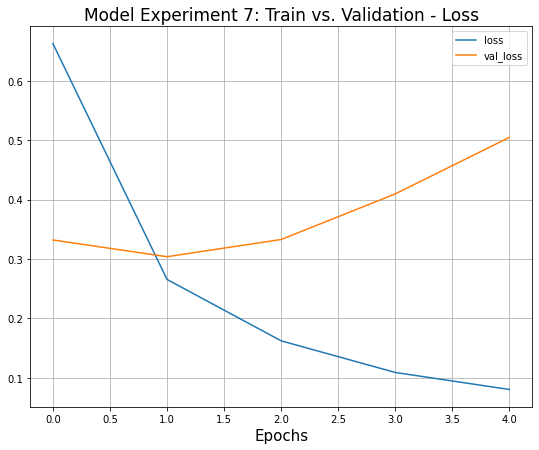

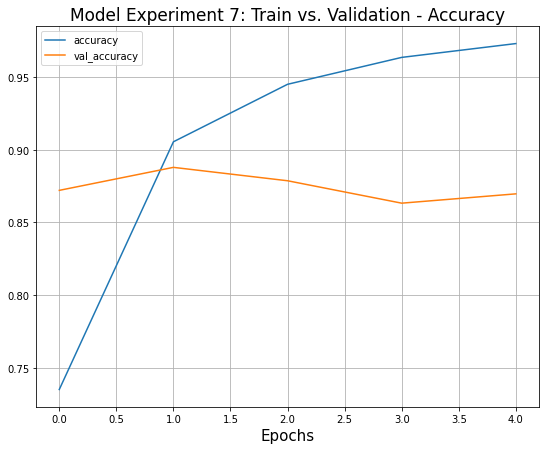

In [45]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_7, model_number)

In [46]:
#creating  classification report

#getting predictions

model_exp_7_predictions=model_exp_7.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_7_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       874
           1       0.99      0.98      0.98       872
           2       0.87      0.89      0.88       839
           3       0.98      0.98      0.98       871
           4       0.67      0.69      0.68       697
           5       0.77      0.74      0.75       847

    accuracy                           0.88      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.88      0.88      0.88      5000

Accuracy Score: 0.8804
Root Mean Square Error: 0.7860025445251434


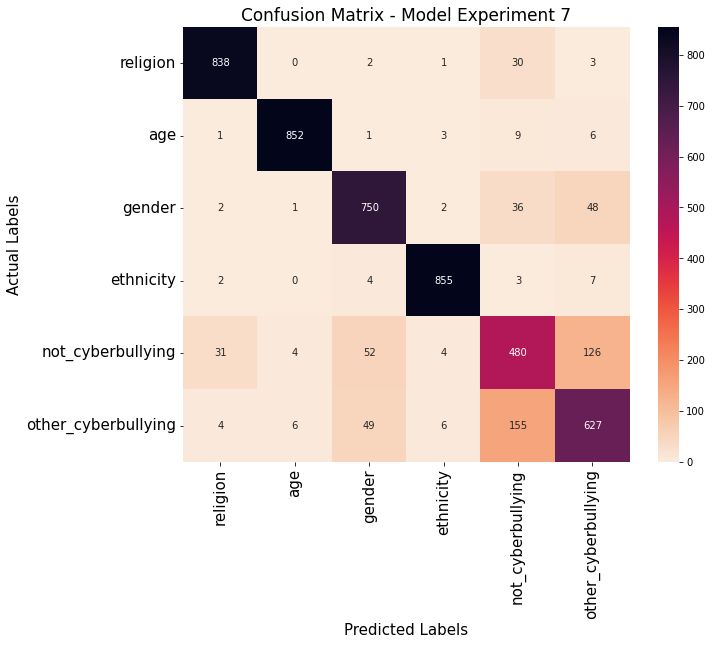

In [47]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_7, X_test_token_pad, y_test, model_number)